# Environment variables

In [0]:
DOWNLOAD_DATASET = False
DATASET_PATH = "dbfs:/project/dataset/dataset.csv"
CHECK_DATABASE_COLUMNS_WITH_NULL_VALUES = False

# Download dataset if needed

In [0]:
if DOWNLOAD_DATASET:
  import os
  # original dataset URL: https://www.kaggle.com/sakhawat18/asteroid-dataset
  os.system('wget -P /tmp https://twitcham.com/dataset.csv')
  dbutils.fs.mv("file:/tmp/dataset.csv", "dbfs:/project/dataset.csv")

# Import libraries

In [0]:
import pyspark
import os
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import when, lit

# Load dataset with pyspark

In [0]:
asteroids_df = spark.read.load(DATASET_PATH, format="csv", sep=",", inferSchema="true", header="true")

# Checks on the dataset

### Columns with missing values

In [0]:
if CHECK_DATABASE_COLUMNS_WITH_NULL_VALUES:
    for column in asteroids_df.columns:
      print("# of missing values of column {} = {}".format(column, asteroids_df.where(col(column).isNull()).count()))

### Count of PHA and NEO

In [0]:
def count_objects(df: DataFrame, column_name: str = "pha"):
  df.groupBy(column_name).count().orderBy('count').show()

In [0]:
count_objects(asteroids_df)
count_objects(asteroids_df, column_name="neo")

+----+------+
 pha| count|
+----+------+
 Y| 2066|
null| 19921|
 N|936537|
+----+------+

+----+------+
 neo| count|
+----+------+
null| 4|
 Y| 22895|
 N|935625|
+----+------+

# Add Q to the dataset
Q is the Aphelion Distance, and we can calculate it as <code>Q = a(1 + e)</code>. This is a feature that could be useful in future. In other datasets it is present, so I can add it.

In [0]:
asteroids_df = asteroids_df.withColumn("Q_ph", (col("a") * (1 + col("e"))))

In [0]:
asteroids_df.select(["Q_ph", "full_name", "a", "e"]).show(n=5, truncate=False)

+------------------+--------------+-----------------+-------------------+
Q_ph |full_name |a |e |
+------------------+--------------+-----------------+-------------------+
2.979646696070851 | 1 Ceres |2.769165148633284|0.0760090265983052 |
3.411748015383405 | 2 Pallas |2.773841434873298|0.2299722588646258 |
3.353864996303052 | 3 Juno |2.66828528813587 |0.2569364345017789 |
2.5709263366965067| 4 Vesta |2.361417893971132|0.08872145978916499|
3.065455345393962 | 5 Astraea|2.574037280352932|0.1909133441041888 |
+------------------+--------------+-----------------+-------------------+
only showing top 5 rows

# Import graphics libraries

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Correlation matrix

In [0]:
def correlation_matrix(df: DataFrame):
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(df.toPandas().corr(), cmap="YlGnBu")

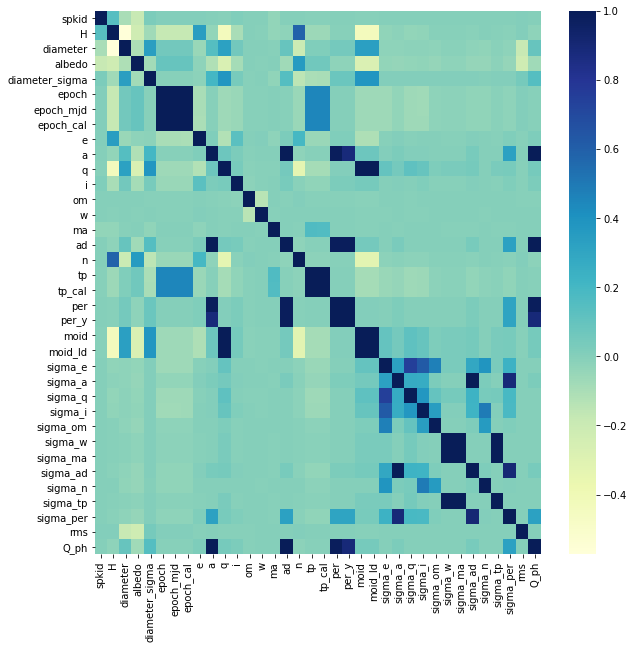

In [0]:
correlation_matrix(asteroids_df)

# Dataset graphics

In [0]:
def show_graphics(df: DataFrame):
  graphics = 5
  fig, ax = plt.subplots(1, graphics, figsize=(25, 5))
  graphics_data = [('moid', 'diameter'), ('a', 'diameter'), ('H', 'moid'), ('H', 'diameter'), ('albedo', 'H')]
  df = df.toPandas()
  for i, j in enumerate(ax):
    x = graphics_data[i][0]
    y = graphics_data[i][1]
    ax[i].scatter(df[x], y=df[y], c=df[x])
    ax[i].set_xlabel(x)
    ax[i].set_ylabel(y)
  plt.show()
  

Here some graphics. We can see the relationship between the <i>diameter</i> and the <i>moid</i>, that is the minimum orbital intersection distance and it represents the collision risk between two objects (in this case the Earth and the asteroid itself). Then, the second graphic, it's the relationship between the <i>diameter</i> and the <i>semi-major axis</i> in terms of <i>au</i>. The third graphic is the relationship between the <i>moid</i> and the <i>absolute magnitude parameter</i>. The fourth is the relationship between the <i>diameter</i> and the <i>absolute magnitude parameter</i>. The latest graphic is the relationship between the <i>absolute magnitude parameter</i> and the <i>albedo</i> that is the measure of the diffuse reflection of solar radiation out of the total solar radiation and measured on a scale from 0.

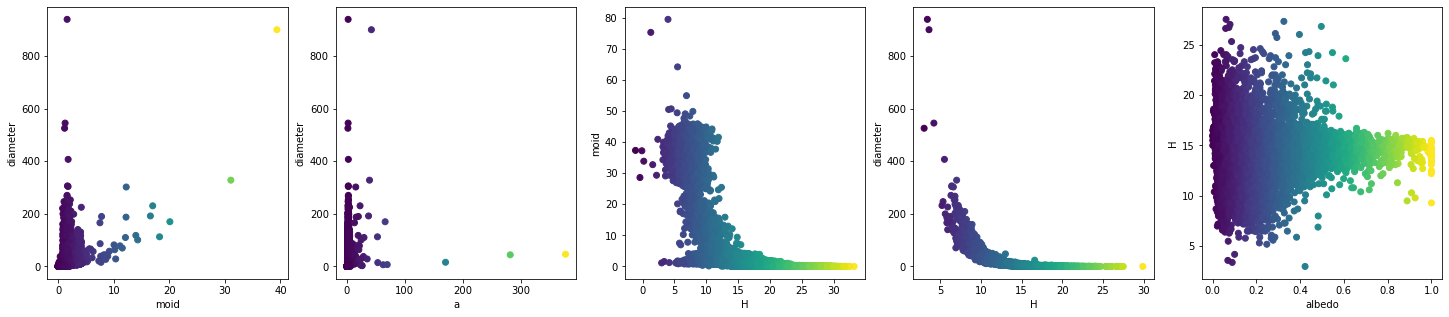

In [0]:
show_graphics(asteroids_df)

# Drop columns

I checked the columns that are useless (i.e the id and the name) and the columns that have many missing values. I simply dropped them.

In [0]:
COLUMNS_TO_DROP = ['id', 'name', 'prefix', 'spkid', 'full_name', 'diameter', 'albedo', 'diameter_sigma', 'pdes', 'equinox']

In [0]:
asteroids_df = asteroids_df.drop(*COLUMNS_TO_DROP)

### Drop samples with null values

There were some sample (they were very few) with NULL values, so I dropped them.

In [0]:
asteroids_df = asteroids_df.dropna(how='any')

In [0]:
count_objects(asteroids_df)
count_objects(asteroids_df, column_name="neo")

+---+------+
pha| count|
+---+------+
 Y| 2066|
 N|930269|
+---+------+

+---+------+
neo| count|
+---+------+
 Y| 22883|
 N|909452|
+---+------+

# Machine Learning Models

In this section I present some machine learning models (in particular the logistic regression, the decision tree and the random forest) about the classification of potentially hazardous asteroids.

In [0]:
def count_objects_with_condition(df: DataFrame, condition_column: str = "neo", column_value: str = "Y", column_name: str = "pha"):
  df.filter(col(condition_column) == column_value).groupBy(column_name).count().orderBy('count').show()

In [0]:
count_objects_with_condition(asteroids_df) # near earth objects that are pha
count_objects_with_condition(asteroids_df, "pha", "Y", "neo") # how many pha are neo

+---+-----+
pha|count|
+---+-----+
 Y| 2066|
 N|20817|
+---+-----+

+---+-----+
neo|count|
+---+-----+
 Y| 2066|
+---+-----+

In [0]:
asteroids_df.printSchema()

root
-- neo: string (nullable = true)
-- pha: string (nullable = true)
-- H: double (nullable = true)
-- orbit_id: string (nullable = true)
-- epoch: double (nullable = true)
-- epoch_mjd: integer (nullable = true)
-- epoch_cal: double (nullable = true)
-- e: double (nullable = true)
-- a: double (nullable = true)
-- q: double (nullable = true)
-- i: double (nullable = true)
-- om: double (nullable = true)
-- w: double (nullable = true)
-- ma: double (nullable = true)
-- ad: double (nullable = true)
-- n: double (nullable = true)
-- tp: double (nullable = true)
-- tp_cal: double (nullable = true)
-- per: double (nullable = true)
-- per_y: double (nullable = true)
-- moid: double (nullable = true)
-- moid_ld: double (nullable = true)
-- sigma_e: double (nullable = true)
-- sigma_a: double (nullable = true)
-- sigma_q: double (nullable = true)
-- sigma_i: double (nullable = true)
-- sigma_om: double (nullable = true)
-- sigma_w: double (nullable = true)
-- sigma_ma: double (nullable = true)
-- sigma_ad: double (nullable = true)
-- sigma_n: double (nullable = true)
-- sigma_tp: double (nullable = true)
-- sigma_per: double (nullable = true)
-- class: string (nullable = true)
-- rms: double (nullable = true)
-- Q_ph: double (nullable = true)

In [0]:
def save_pyspark_model(model, filename: str) -> None:
  model.write().overwrite().save("dbfs:/project/models/" + filename)

### PHA classification

#### Define the pipeline
Here I defined a general pipeline for all the models.

In [0]:
from typing import List, Callable
def general_pipeline(df: DataFrame, numerical_features: List[str], categorical_features: List[str], target_variable: str, with_std: bool = True, with_mean: bool = True, scaler: bool = False):
  from pyspark.ml import Pipeline
  from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
  
  indexers = [StringIndexer(inputCol=c, outputCol="{}_indexed".format(c), handleInvalid="keep") for c in categorical_features]
  
  encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=["{}_encoded".format(indexer.getOutputCol()) for indexer in indexers], handleInvalid="keep")
  
  label_indexer = StringIndexer(inputCol=target_variable, outputCol="label")
  
  assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")
  
  if scaler:
    scaler_vect = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    stages = indexers + [encoder] + [label_indexer] + [assembler] + [scaler_vect]
  else:
    stages = indexers + [encoder] + [label_indexer] + [assembler]
    
  pipeline = Pipeline(stages=stages)
  transformer = pipeline.fit(df)
  df_transformed = transformer.transform(df)
  return transformer, df_transformed

In [0]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
NEAs_df = asteroids_df.where(col("neo") == "Y")
print("# of samples: {}".format(NEAs_df.count()))

# of samples: 22883

In [0]:
# experiments: dict with tuples as values (oversampled, path, dataset_used, model, standardized), dataset_used = 0, 1 -> all asteroids, near earth asteroids
# just comment experiments to avoid!
experiments = {
  #"logistic_regression_no_std": (False, "log_reg_model_no_std", 0, LogisticRegression, False),
  #"logistic_regression_std": (False, "log_reg_model_std", 0, LogisticRegression, True),
  #"logistic_regression_oversampled_no_std": (True, "log_reg_model_oversampled_no_std", 0, LogisticRegression, False),
  #"logistic_regression_oversampled_std": (True, "log_reg_model_oversampled_std", 0, LogisticRegression, True),
  #"logistic_regression_std_nea": (False, "log_reg_model_std_nea", 1, LogisticRegression, True),
  #"logistic_regression_no_std_nea": (False, "log_reg_model_no_std_nea", 1, LogisticRegression, False),
  #"logistic_regression_oversampled_no_std_nea": (True, "log_reg_model_oversampled_no_std_nea", 1, LogisticRegression, False),
  #"logistic_regression_oversampled_std_nea": (True, "log_reg_model_oversampled_std_nea", 1, LogisticRegression, True),
  
  #"dec_tree_no_std": (False, "dec_tree_no_std", 0, DecisionTreeClassifier, False),
  #"dec_tree_std": (False, "dec_tree_std", 0, DecisionTreeClassifier, True),
  #"decision_tree_oversampled_no_std": (True, "decision_tree_oversampled_no_std", 0, DecisionTreeClassifier, False),
  #"decision_tree_oversampled_std": (True, "decision_tree_oversampled_std", 0, DecisionTreeClassifier, True),
  #"dec_tree_std_nea": (False, "dec_tree_std_nea", 1, DecisionTreeClassifier, True),
  #"dec_tree_no_std_nea": (False, "dec_tree_no_std_nea", 1, DecisionTreeClassifier, False),
  #"decision_tree_oversampled_no_std_nea": (True, "decision_tree_oversampled_no_std_nea", 1, DecisionTreeClassifier, False),
  #"decision_tree_oversampled_std_nea": (True, "decision_tree_oversampled_std_nea", 1, DecisionTreeClassifier, True),
  
  #"random_forest_no_std": (False, "random_forest_no_std", 0, RandomForestClassifier, False),
  #"random_forest_std": (False, "random_forest_std", 0, RandomForestClassifier, True),
  #"random_forest_oversampled_no_std": (True, "random_forest_oversampled_no_std", 0, RandomForestClassifier, False),
  #"random_forest_oversampled_std": (True, "random_forest_oversampled_std", 0, RandomForestClassifier, True),
  #"random_forest_std_nea": (False, "random_forest_std_nea", 1, RandomForestClassifier, True),
  #"random_forest_no_std_nea": (False, "random_forest_no_std_nea", 1, RandomForestClassifier, False),
  #"random_forest_oversampled_no_std_nea": (True, "random_forest_oversampled_no_std_nea", 1, RandomForestClassifier, False),
  #"random_forest_oversampled_std_nea": (True, "random_forest_oversampled_std_nea", 1, RandomForestClassifier, True)
}

datasets_map = {0: asteroids_df, 1: NEAs_df}
datasets_map_name = {0: "all", 1: "nea"}

CATEGORICAL_FEATURES = ["orbit_id", "class"] # they are the CATEGORICAL FEATURES
NUMERICAL_FEATURES = ["H", "epoch", "epoch_mjd", "epoch_cal", "e", "a", "q", "i", "om", "w", "ma", "ad", "n", "tp", "tp_cal", "per", "per_y", "moid", "moid_ld", "sigma_e", "sigma_a", "sigma_q", "sigma_i", "sigma_om", "sigma_w", "sigma_ad", "sigma_n", "sigma_tp", "sigma_per", "rms", "Q_ph"]

In [0]:
def plot_precision_recall(model):
  training_summary = model.summary
  precision_recall = training_summary.pr.toPandas()
  fig, ax = plt.subplots(1, 1, figsize=(8,6))
  _ = sns.lineplot(x=precision_recall['recall'], y=precision_recall['precision'], marker="s", axes=ax)
  _ = ax.set_xlabel("Recall", labelpad=20)
  _ = ax.set_ylabel("Precision", labelpad=20)
  _ = ax.set_title("Precision vs. Recall")

In [0]:
import numpy as np
def plot_coefficients(model):
  theta = np.sort(model.coefficients)
  fig, ax = plt.subplots(1, 1, figsize=(8,6))
  _ = sns.lineplot(x=range(0,len(model.coefficients)), y=theta, marker="o", axes=ax)
  _ = ax.set_xlabel("Theta Index", labelpad=20)
  _ = ax.set_ylabel("Theta Value (log odds)", labelpad=20)

In [0]:
def plot_roc(model):
  roc = model.summary.roc.toPandas()

  fig, ax = plt.subplots(1, 1, figsize=(8,6))
  _ = sns.lineplot(x=roc['FPR'], y=roc['TPR'], marker="s", axes=ax)
  _ = ax.set_xlabel("False Positive Rate", labelpad=20)
  _ = ax.set_ylabel("True Positive Rate", labelpad=20)
  _ = ax.set_title("ROC Curve")
  print('Training Set AUC: {:.3f}'.format(model.summary.areaUnderROC))

In [0]:
import itertools
import numpy as np
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix without normalization")
  
  print(cm)
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [0]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(predictions):
  y_true = predictions.select("label")
  y_true = y_true.toPandas()

  y_pred = predictions.select("prediction")
  y_pred = y_pred.toPandas()

  confusion_matrix_lr = confusion_matrix(y_true, y_pred, labels=[0.0, 1.0])
  plt.figure()
  plot_confusion_matrix(confusion_matrix_lr, classes=[0.0, 1.0], title='Confusion matrix lr')
  plt.show()

In [0]:

def metrics_calculation(y_test, pred):
  precision = precision_score(y_test, pred, average = "macro")
  recall = recall_score(y_test, pred, average = "macro")
  accuracy = accuracy_score(y_test, pred)
  f1score = f1_score(y_test, pred, average = "macro")
  print('Precision metric: {}'.format(precision))
  print('Recall Metric: {}'.format(recall))
  print('Accuracy Metric: {}'.format(accuracy))
  print('F1-score Metric: {}'.format(f1score))
  

In [0]:
RUN_EXPERIMENTS = False
# this could take a very long time!
if RUN_EXPERIMENTS:
  for experiment in experiments:
    oversampled, model_folder, dataset, model, standardized = experiments[experiment]
    #try:
    #  check_model_folder = dbutils.fs.ls("project/models/" + model_folder) # check if the model exists!
    #except:
      # otherwise we build the model.
    if dataset == 0:
      train_df, test_df = asteroids_df.randomSplit([0.7, 0.3], seed=42)
    else:
      train_df, test_df = NEAs_df.randomSplit([0.7, 0.3], seed=42)

    print("Training set size: {:d} instances".format(train_df.count()))
    print("Test set size: {:d} instances".format(test_df.count()))
    
    if oversampled:
      train_df_class_0 = train_df[train_df['pha'] == "N"]
      train_df_class_1 = train_df[train_df['pha'] == "Y"]
      train_df_class_1_oversampled = train_df_class_1.sample(withReplacement=True, fraction=train_df_class_0.count() / train_df_class_1.count(), seed=42)
      train_df = train_df_class_0.unionAll(train_df_class_1_oversampled)

    column_features = "std_features" if standardized else "features"
    transformer, train_df_transformed = general_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, "pha", scaler=standardized)
    train_df_transformed = train_df_transformed.select([column_features, "label"])


    print("STARTING TRAINING EXPERIMENT " + experiment)

    if model == LogisticRegression:
      training = model(featuresCol = column_features, labelCol = "label", maxIter=100)
    else:
      training = model(featuresCol = column_features, labelCol = "label")
        

    training_model = training.fit(train_df_transformed)

    test_df_transformed = transformer.transform(test_df)
    test_df_transformed = test_df_transformed.select([column_features, "label"])
    predictions = training_model.transform(test_df_transformed)

    print("METRICS FOR EXPERIMENT " + experiment)

    calculate_metrics(predictions)
    metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
    evaluator = BinaryClassificationEvaluator()
    print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(predictions)))

    save_pyspark_model(training_model, experiment + "_" + datasets_map_name[dataset])

    print("============================================================")
    #break

#### Logistic regression
Show the results for logistic regression experiments (loading the previous models)

In [0]:
from pyspark.ml.classification import LogisticRegressionModel

logistic_regression_experiments = [("logistic_regression_no_std_all", 0, False), ("logistic_regression_no_std_nea_nea", 1, False), ("logistic_regression_oversampled_no_std_all", 0, False), ("logistic_regression_oversampled_no_std_nea_nea", 1, False), ("logistic_regression_oversampled_std_all", 0, True), ("logistic_regression_oversampled_std_nea_nea", 1, True), ("logistic_regression_std_all", 0, True), ("logistic_regression_std_nea_nea", 1, True)]

In [0]:
train_df_asteroids, test_df_asteroids = asteroids_df.randomSplit([0.7, 0.3], seed=42)
train_df_nea, test_df_nea = NEAs_df.randomSplit([0.7, 0.3], seed=42)

transformer_asteroids_not_scaled, train_df_asteroids_not_scaled_transformed = build_pipeline_logistic(train_df_asteroids, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, "pha", scaler=False)
transformer_asteroids_scaled, train_df_asteroids_scaled_transformed = build_pipeline_logistic(train_df_asteroids, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, "pha", scaler=True)

transformer_nea_not_scaled, train_df_asteroids_not_scaled_transformed = build_pipeline_logistic(train_df_nea, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, "pha", scaler=False)
transformer_nea_scaled, train_df_nea_scaled_transformed = build_pipeline_logistic(train_df_nea, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, "pha", scaler=True)

test_df_asteroids_not_scaled = transformer_asteroids_not_scaled.transform(test_df_asteroids).select(["features", "label"])
test_df_asteroids_scaled = transformer_asteroids_scaled.transform(test_df_asteroids).select(["std_features", "label"])

test_df_nea_not_scaled = transformer_nea_not_scaled.transform(test_df_nea).select(["features", "label"])
test_df_nea_scaled = transformer_nea_scaled.transform(test_df_nea).select(["std_features", "label"])

METRICS FOR EXPERIMENT logistic_regression_no_std_all
Confusion matrix without normalization
[[278542 163]
 [ 539 116]]

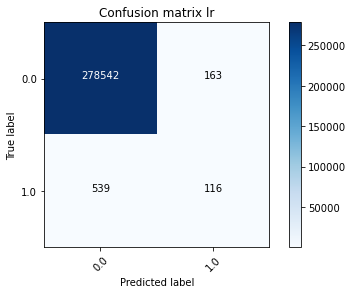

Precision metric: 0.7069196351943609
Recall Metric: 0.5882571944315523
Accuracy Metric: 0.9974871134020619
F1-score Metric: 0.6235677285489463
Test Set AUC: 0.996
==================================
METRICS FOR EXPERIMENT logistic_regression_no_std_nea_nea
Confusion matrix without normalization
[[6200 0]
 [ 583 0]]

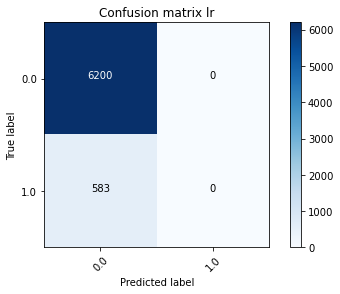

/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
Precision metric: 0.4570249152292496
Recall Metric: 0.5
Accuracy Metric: 0.9140498304584992
F1-score Metric: 0.4775475621967188
Test Set AUC: 0.930
==================================
METRICS FOR EXPERIMENT logistic_regression_oversampled_no_std_all
Confusion matrix without normalization
[[273824 4881]
 [ 379 276]]

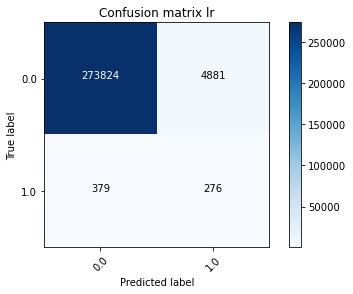

Precision metric: 0.5260686502125828
Recall Metric: 0.7019304523333174
Accuracy Metric: 0.9811712485681557
F1-score Metric: 0.542731287574374
Test Set AUC: 0.936
==================================
METRICS FOR EXPERIMENT logistic_regression_oversampled_no_std_nea_nea
Confusion matrix without normalization
[[5732 468]
 [ 62 521]]

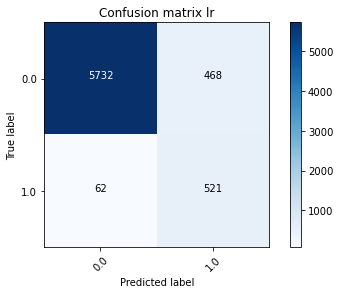

Precision metric: 0.7580470086379935
Recall Metric: 0.9090848226636419
Accuracy Metric: 0.9218634822349993
F1-score Metric: 0.8093305558631734
Test Set AUC: 0.961
==================================
METRICS FOR EXPERIMENT logistic_regression_oversampled_std_all
Confusion matrix without normalization
[[263783 14922]
 [ 199 456]]

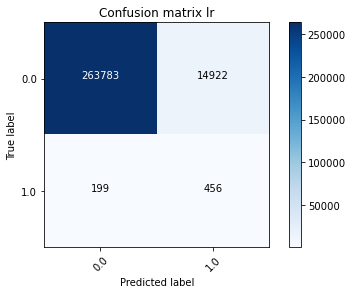

Precision metric: 0.5144494557029365
Recall Metric: 0.8213213621176787
Accuracy Metric: 0.9458727090492555
F1-score Metric: 0.5145097364369166
Test Set AUC: 0.908
==================================
METRICS FOR EXPERIMENT logistic_regression_oversampled_std_nea_nea
Confusion matrix without normalization
[[4352 1848]
 [ 16 567]]

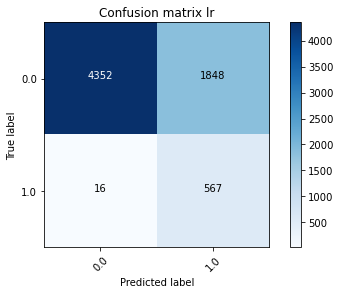

Precision metric: 0.6155598025163243
Recall Metric: 0.8372456150058097
Accuracy Metric: 0.7251953412944125
F1-score Metric: 0.6009353194837437
Test Set AUC: 0.960
==================================
METRICS FOR EXPERIMENT logistic_regression_std_all
Confusion matrix without normalization
[[278551 154]
 [ 438 217]]

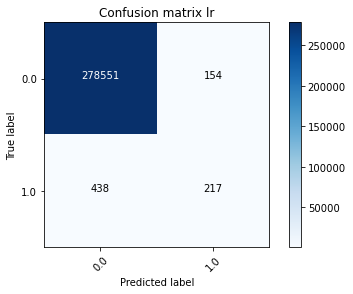

Precision metric: 0.7916678530031989
Recall Metric: 0.6653725771770775
Accuracy Metric: 0.9978808705612829
F1-score Metric: 0.7109702176487527
Test Set AUC: 0.963
==================================
METRICS FOR EXPERIMENT logistic_regression_std_nea_nea
Confusion matrix without normalization
[[6050 150]
 [ 148 435]]

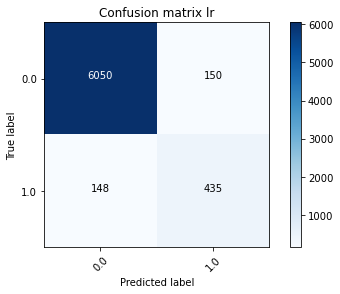

Precision metric: 0.8598555365254301
Recall Metric: 0.8609735517069662
Accuracy Metric: 0.9560666371811882
F1-score Metric: 0.8604134394190844
Test Set AUC: 0.971
==================================

In [0]:
for exp in logistic_regression_experiments:
  experiment, dataset, standardized = exp
  model = LogisticRegressionModel.load("dbfs:/project/models/" + experiment)
  
  if not standardized and dataset == 0:
    test_dataset = test_df_asteroids_not_scaled
  elif standardized and dataset == 0:
    test_dataset = test_df_asteroids_scaled
  elif not standardized and dataset == 1:
    test_dataset = test_df_nea_not_scaled
  else:
    test_dataset = test_df_nea_scaled
  
  predictions = model.transform(test_dataset)

  print("METRICS FOR EXPERIMENT " + experiment)
  calculate_metrics(predictions)
  metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  evaluator = BinaryClassificationEvaluator()
  print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(predictions)))
  print("==================================")

#### Decision tree
Show the results for decision tree experiments.

In [0]:
from pyspark.ml.classification import DecisionTreeClassificationModel

In [0]:
decision_tree_experiments = [("dec_tree_no_std_all", 0, False), ("dec_tree_no_std_nea_nea", 1, False), ("dec_tree_std_all", 0, True), ("dec_tree_std_nea_nea", 1, True), ("decision_tree_oversampled_no_std_all", 0, False), ("decision_tree_oversampled_no_std_nea_nea", 1, False), ("decision_tree_oversampled_std_all", 0, True), ("decision_tree_oversampled_std_nea_nea", 1, True)]

METRICS FOR EXPERIMENT dec_tree_no_std_all
Confusion matrix without normalization
[[278596 109]
 [ 533 122]]

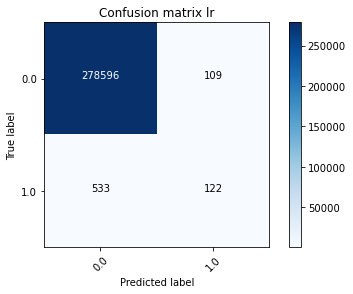

Precision metric: 0.7631145083828252
Recall Metric: 0.5929342237291311
Accuracy Metric: 0.9977018900343643
F1-score Metric: 0.6371220769245729
Test Set AUC: 0.993
==================================
METRICS FOR EXPERIMENT dec_tree_no_std_nea_nea
Confusion matrix without normalization
[[6179 21]
 [ 17 566]]

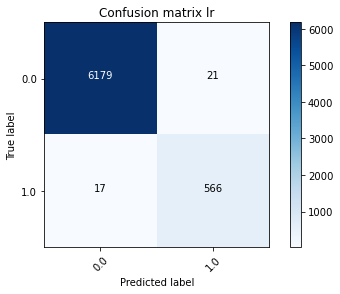

Precision metric: 0.9807405833075798
Recall Metric: 0.9837266917501245
Accuracy Metric: 0.9943977591036415
F1-score Metric: 0.9822279312598771
Test Set AUC: 0.998
==================================
METRICS FOR EXPERIMENT dec_tree_std_all
Confusion matrix without normalization
[[278611 94]
 [ 535 120]]

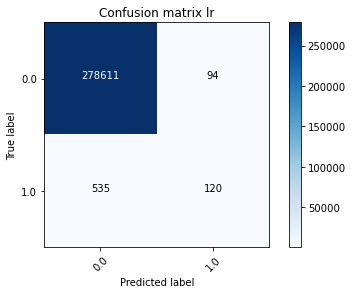

Precision metric: 0.7794155518791593
Recall Metric: 0.5914344163457189
Accuracy Metric: 0.9977484249713631
F1-score Metric: 0.63752598773034
Test Set AUC: 0.833
==================================
METRICS FOR EXPERIMENT dec_tree_std_nea_nea
Confusion matrix without normalization
[[6174 26]
 [ 16 567]]

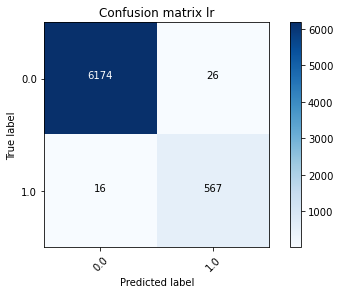

Precision metric: 0.9767851645612382
Recall Metric: 0.9841810988767775
Accuracy Metric: 0.9938080495356038
F1-score Metric: 0.9804479418886198
Test Set AUC: 0.994
==================================
METRICS FOR EXPERIMENT decision_tree_oversampled_no_std_all
Confusion matrix without normalization
[[276565 2140]
 [ 7 648]]

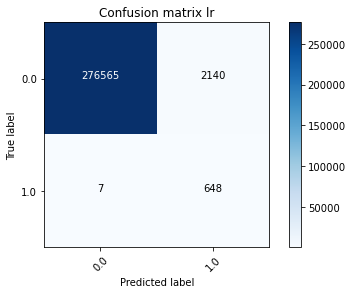

Precision metric: 0.6161996836614431
Recall Metric: 0.9908173037484844
Accuracy Metric: 0.9923145761741122
F1-score Metric: 0.6862746888347615
Test Set AUC: 0.994
==================================
METRICS FOR EXPERIMENT decision_tree_oversampled_no_std_nea_nea
Confusion matrix without normalization
[[6158 42]
 [ 2 581]]

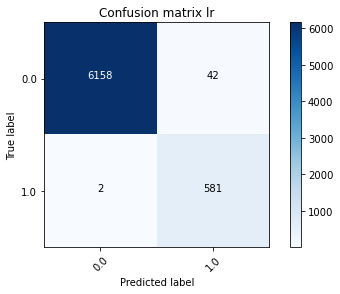

Precision metric: 0.966129797169123
Recall Metric: 0.9948976373595972
Accuracy Metric: 0.9935131947515848
F1-score Metric: 0.9799779420051844
Test Set AUC: 0.998
==================================
METRICS FOR EXPERIMENT decision_tree_oversampled_std_all
Confusion matrix without normalization
[[267641 11064]
 [ 8 647]]

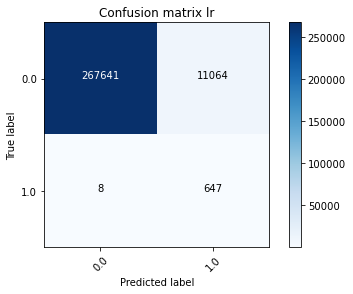

Precision metric: 0.5276086567953989
Recall Metric: 0.9740441855468127
Accuracy Metric: 0.9603665521191295
F1-score Metric: 0.5421882551964872
Test Set AUC: 0.985
==================================
METRICS FOR EXPERIMENT decision_tree_oversampled_std_nea_nea
Confusion matrix without normalization
[[5355 845]
 [ 0 583]]

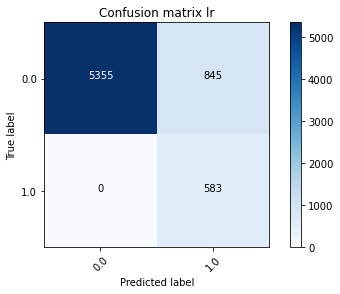

Precision metric: 0.7041316526610644
Recall Metric: 0.9318548387096774
Accuracy Metric: 0.8754238537520271
F1-score Metric: 0.7533412617449549
Test Set AUC: 0.951
==================================

In [0]:
for exp in decision_tree_experiments:
  experiment, dataset, standardized = exp
  model = DecisionTreeClassificationModel.load("dbfs:/project/models/" + experiment)
  
  if not standardized and dataset == 0:
    test_dataset = test_df_asteroids_not_scaled
  elif standardized and dataset == 0:
    test_dataset = test_df_asteroids_scaled
  elif not standardized and dataset == 1:
    test_dataset = test_df_nea_not_scaled
  else:
    test_dataset = test_df_nea_scaled
  
  predictions = model.transform(test_dataset)

  print("METRICS FOR EXPERIMENT " + experiment)
  calculate_metrics(predictions)
  metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  evaluator = BinaryClassificationEvaluator()
  print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(predictions)))
  print("==================================")

#### Random forest
Show results of the random forest models.

In [0]:
from pyspark.ml.classification import RandomForestClassificationModel

In [0]:
decision_tree_experiments = [("random_forest_no_std_all", 0, False), ("random_forest_no_std_nea_nea", 1, False), ("random_forest_std_all", 0, True), ("random_forest_std_nea_nea", 1, True), ("random_forest_oversampled_no_std_all", 0, False), ("random_forest_oversampled_no_std_nea_nea", 1, False), ("random_forest_oversampled_std_all", 0, True), ("random_forest_oversampled_std_nea_nea", 1, True)]

METRICS FOR EXPERIMENT random_forest_no_std_all
Confusion matrix without normalization
[[278705 0]
 [ 655 0]]

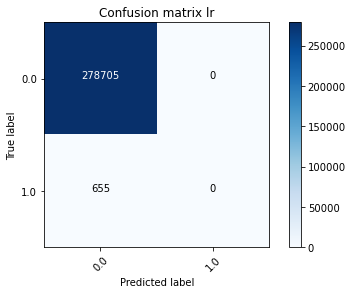

/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
Precision metric: 0.4988276775486827
Recall Metric: 0.5
Accuracy Metric: 0.9976553550973654
F1-score Metric: 0.49941315079784615
Test Set AUC: 0.996
==================================
METRICS FOR EXPERIMENT random_forest_no_std_nea_nea
Confusion matrix without normalization
[[6200 0]
 [ 581 2]]

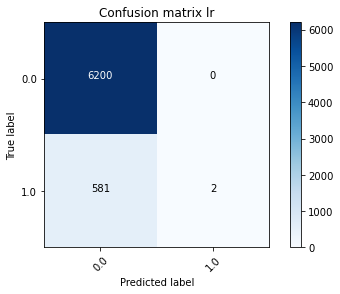

Precision metric: 0.957159710957086
Recall Metric: 0.5017152658662093
Accuracy Metric: 0.9143446852425181
F1-score Metric: 0.4810399420059693
Test Set AUC: 0.976
==================================
METRICS FOR EXPERIMENT random_forest_std_all
Confusion matrix without normalization
[[278705 0]
 [ 655 0]]

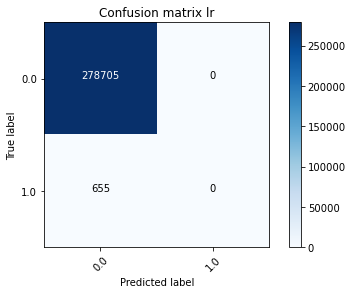

Precision metric: 0.4988276775486827
Recall Metric: 0.5
Accuracy Metric: 0.9976553550973654
F1-score Metric: 0.49941315079784615
Test Set AUC: 0.996
==================================
METRICS FOR EXPERIMENT random_forest_std_nea_nea
Confusion matrix without normalization
[[6200 0]
 [ 583 0]]

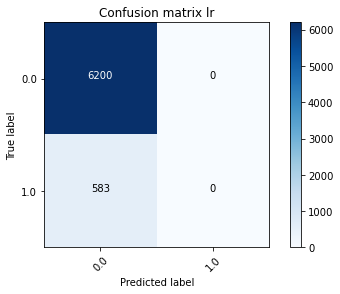

Precision metric: 0.4570249152292496
Recall Metric: 0.5
Accuracy Metric: 0.9140498304584992
F1-score Metric: 0.4775475621967188
Test Set AUC: 0.962
==================================
METRICS FOR EXPERIMENT random_forest_oversampled_no_std_all
Confusion matrix without normalization
[[272753 5952]
 [ 7 648]]

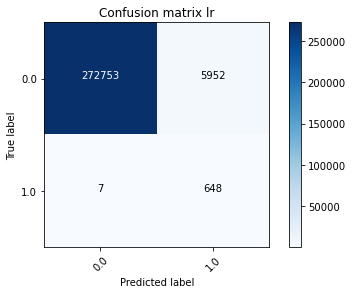

Precision metric: 0.549078077297391
Recall Metric: 0.9839785315700162
Accuracy Metric: 0.9786691008018328
F1-score Metric: 0.5839148305069468
Test Set AUC: 0.997
==================================
METRICS FOR EXPERIMENT random_forest_oversampled_no_std_nea_nea
Confusion matrix without normalization
[[5335 865]
 [ 80 503]]

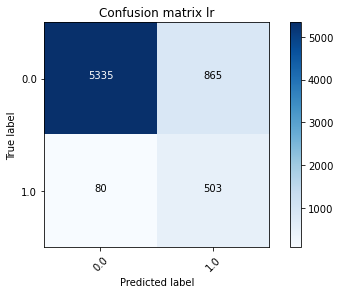

Precision metric: 0.6764581409664512
Recall Metric: 0.8616313008355005
Accuracy Metric: 0.8606811145510835
F1-score Metric: 0.7171363493847212
Test Set AUC: 0.967
==================================
METRICS FOR EXPERIMENT random_forest_oversampled_std_all
Confusion matrix without normalization
[[249529 29176]
 [ 0 655]]

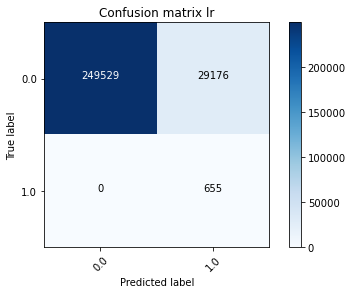

Precision metric: 0.5109785122858771
Recall Metric: 0.9476579178701494
Accuracy Metric: 0.895561282932417
F1-score Metric: 0.4938687232015868
Test Set AUC: 0.990
==================================
METRICS FOR EXPERIMENT random_forest_oversampled_std_nea_nea
Confusion matrix without normalization
[[5676 524]
 [ 59 524]]

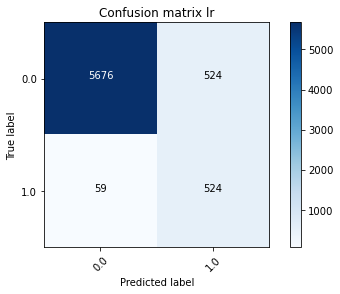

Precision metric: 0.7448561464690497
Recall Metric: 0.9071415924306978
Accuracy Metric: 0.9140498304584992
F1-score Metric: 0.7968513280987322
Test Set AUC: 0.960
==================================

In [0]:
for exp in decision_tree_experiments:
  experiment, dataset, standardized = exp
  model = RandomForestClassificationModel.load("dbfs:/project/models/" + experiment)
  
  if not standardized and dataset == 0:
    test_dataset = test_df_asteroids_not_scaled
  elif standardized and dataset == 0:
    test_dataset = test_df_asteroids_scaled
  elif not standardized and dataset == 1:
    test_dataset = test_df_nea_not_scaled
  else:
    test_dataset = test_df_nea_scaled
  
  predictions = model.transform(test_dataset)

  print("METRICS FOR EXPERIMENT " + experiment)
  calculate_metrics(predictions)
  metrics_calculation(predictions.select("label").toPandas(), predictions.select("prediction").toPandas())
  evaluator = BinaryClassificationEvaluator()
  print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(predictions)))
  print("==================================")

### Diameter prediction
In this case, I worked on a regression problem. In particular I focused on predicting the diameter of the asteroids.

In [0]:
asteroids_df = spark.read.load(DATASET_PATH, format="csv", sep=",", inferSchema="true", header="true")
asteroids_df = asteroids_df.withColumn("Q_ph", (col("a") * (1 + col("e"))))


COLUMNS_TO_DROP = ['id', 'name', 'prefix', 'spkid', 'full_name', 'albedo', 'diameter_sigma', 'pdes', 'equinox']
asteroids_df = asteroids_df.drop(*COLUMNS_TO_DROP)

In [0]:
asteroids_diameter_df = asteroids_df.where(col("diameter").isNotNull())

In [0]:
asteroids_diameter_df.count()

Out[29]: 136209

In [0]:
for column in asteroids_diameter_df.columns:
      print("# of missing values of column {} = {}".format(column, asteroids_diameter_df.where(col(column).isNull()).count()))

# of missing values of column neo = 0
# of missing values of column pha = 0
# of missing values of column H = 4164
# of missing values of column diameter = 0
# of missing values of column orbit_id = 0
# of missing values of column epoch = 0
# of missing values of column epoch_mjd = 0
# of missing values of column epoch_cal = 0
# of missing values of column e = 0
# of missing values of column a = 0
# of missing values of column q = 0
# of missing values of column i = 0
# of missing values of column om = 0
# of missing values of column w = 0
# of missing values of column ma = 0
# of missing values of column ad = 0
# of missing values of column n = 0
# of missing values of column tp = 0
# of missing values of column tp_cal = 0
# of missing values of column per = 0
# of missing values of column per_y = 0
# of missing values of column moid = 0
# of missing values of column moid_ld = 0
# of missing values of column sigma_e = 0
# of missing values of column sigma_a = 0
# of missing values of column sigma_q = 0
# of missing values of column sigma_i = 0
# of missing values of column sigma_om = 0
# of missing values of column sigma_w = 0
# of missing values of column sigma_ma = 0
# of missing values of column sigma_ad = 0
# of missing values of column sigma_n = 0
# of missing values of column sigma_tp = 0
# of missing values of column sigma_per = 0
# of missing values of column class = 0
# of missing values of column rms = 0
# of missing values of column Q_ph = 0

In [0]:
asteroids_diameter_df = asteroids_diameter_df.dropna(how='any')

In [0]:
for column in asteroids_diameter_df.columns:
      print("# of missing values of column {} = {}".format(column, asteroids_diameter_df.where(col(column).isNull()).count()))

# of missing values of column neo = 0
# of missing values of column pha = 0
# of missing values of column H = 0
# of missing values of column diameter = 0
# of missing values of column orbit_id = 0
# of missing values of column epoch = 0
# of missing values of column epoch_mjd = 0
# of missing values of column epoch_cal = 0
# of missing values of column e = 0
# of missing values of column a = 0
# of missing values of column q = 0
# of missing values of column i = 0
# of missing values of column om = 0
# of missing values of column w = 0
# of missing values of column ma = 0
# of missing values of column ad = 0
# of missing values of column n = 0
# of missing values of column tp = 0
# of missing values of column tp_cal = 0
# of missing values of column per = 0
# of missing values of column per_y = 0
# of missing values of column moid = 0
# of missing values of column moid_ld = 0
# of missing values of column sigma_e = 0
# of missing values of column sigma_a = 0
# of missing values of column sigma_q = 0
# of missing values of column sigma_i = 0
# of missing values of column sigma_om = 0
# of missing values of column sigma_w = 0
# of missing values of column sigma_ma = 0
# of missing values of column sigma_ad = 0
# of missing values of column sigma_n = 0
# of missing values of column sigma_tp = 0
# of missing values of column sigma_per = 0
# of missing values of column class = 0
# of missing values of column rms = 0
# of missing values of column Q_ph = 0

#### Linear Regression

In [0]:
def regression_pipeline(df, numerical_features, categorical_features, target_variable, k_fold=5):
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.regression import LinearRegression

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]


    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")
    
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=True, withMean=True)

    
    if target_variable != "label":
        df = df.withColumnRenamed(target_variable, "label")
    
    lr = LinearRegression(featuresCol="std_features", labelCol="label")
    
    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [scaler] + [lr])
    
    param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )
    
    cv_model = cross_val.fit(df)
    best_pipeline_model = cv_model.bestModel
    
    return cv_model, best_pipeline_model

In [0]:
train_df, test_df = asteroids_diameter_df.randomSplit([0.7, 0.3], seed=42)

In [0]:
cv_model, best_pipeline_model_lr = regression_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, "diameter")

In [0]:
predictions_train = best_pipeline_model_lr.transform(train_df)

In [0]:
def evaluate_model(predictions, metric="rmse"):
    from pyspark.ml.evaluation import RegressionEvaluator
    evaluator = RegressionEvaluator(labelCol="diameter",
                                    predictionCol="prediction",
                                    metricName=metric)
    return evaluator.evaluate(predictions)

In [0]:
def r2_adj(predictions):
    
    r2 = evaluate_model(predictions, metric="r2")
    r2_adj_score = (1 - (1 - r2) * ((predictions.count() - 1) / (predictions.count() - predictions.select('features').first()[0].size - 1)))

    return r2_adj_score

In [0]:
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_train)))
print("R2: {:.3f}".format(evaluate_model(predictions_train, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_train)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 5.832
R2: 0.614
Adjusted R2: 0.613
***** Training Set *****

In [0]:
predictions_val = best_pipeline_model_lr.transform(test_df)

In [0]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_val)))
print("R2: {:.3f}".format(evaluate_model(predictions_val, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_val)))
print("***** Test Set *****")

***** Validation Set *****
RMSE: 6.589
R2: 0.559
Adjusted R2: 0.555
***** Validation Set *****

In [0]:
predictions_val.select("std_features", "prediction", "diameter").show(1000)

+--------------------+------------------+--------+
 std_features| prediction|diameter|
+--------------------+------------------+--------+
[-0.2026897090132...| 266.5254431967144| 900.0|
[-0.2026897090132...| 98.22579565121691| 407.12|
[-0.2026897090132...| 70.70826706654665| 166.0|
[-0.2026897090132...| 87.51537564553024| 185.18|
[-0.2026897090132...|37.767652678364776| 226.0|
[-0.2026897090132...|100.48329236306354| 179.484|
[-0.2026897090132...| 67.29773582741082| 190.0|
[-0.2026897090132...| 129.1982056622718| 148.97|
[-0.2026897090132...| 98.71372266690285| 142.887|
[-0.2026897090132...| 34.70442805889811| 147.491|
[-0.2026897090132...| 69.2487192834582| 152.0|
[-0.2026897090132...| 77.34452848068392| 302.0|
[-0.2026897090132...| 141.935629932887| 126.42|
[-0.2026897090132...|103.22732553539143| 253.9|
[-0.2026897090132...|142.40206088322057| 202.636|
[-0.2026897090132...| 41.43221485031766| 253.051|
[-0.2026897090132...|128.86724288575633| 267.08|
[-0.2026897090132...| 94.6181099441603| 230.5|
[-0.2026897090132...|100.81351828205896| 111.251|
[-0.2026897090132...| 34.93009696271842| 112.59|
[-0.2026897090132...|194.76409331291387| 328.0|
[-0.2026897090132...| 65.31639299698558| 83.42|
[-0.2026897090132...|108.32764589270033| 180.652|
[-0.2026897090132...|111.20921763794155| 210.37|
[-0.2026897090132...|112.81276268418475| 113.0|
[-0.2026897090132...| 32.77311261693112| 232.0|
[-0.2026897090132...| 33.55715329806557| 86.447|
[-0.2026897090132...|107.42207036256129| 175.859|
[-0.2026897090132...| 100.8914960867504| 198.0|
[-0.2026897090132...|32.129111849458305| 205.495|
[-0.2026897090132...| 34.28171273348062| 216.0|
[-0.2026897090132...| 102.3016112707755| 95.76|
[-0.2026897090132...| 66.7357367678074| 173.642|
[-0.2026897090132...|103.86682355475418| 83.908|
[-0.2026897090132...|126.47100930974601| 204.89|
[-0.2026897090132...|126.60892105061252| 154.79|
[-0.2026897090132...|104.35255740815762| 75.949|
[-0.2026897090132...|30.582865709832085| 160.12|
[-0.2026897090132...|34.134789793404416| 161.667|
[-0.2026897090132...| 101.3831206728089| 162.515|
[-0.2026897090132...| 57.06323644976897| 180.083|
[-0.2026897090132...| 87.3824280162979| 71.34|
[-0.2026897090132...| 72.32071463222445| 90.647|
[-0.2026897090132...| 42.30995242913305| 131.038|
[-0.2026897090132...| 118.1443725763116| 125.821|
[-0.2026897090132...| 90.68550713583116| 145.423|
[-0.2026897090132...|57.243343535630984| 76.0|
[-0.2026897090132...| 152.7012897775417| 88.648|
[-0.2026897090132...|106.32293515559913| 159.331|
[-0.2026897090132...|106.39906387323335| 57.621|
[-0.2026897090132...| 93.47373267240586| 79.24|
[-0.2026897090132...| 40.42435412138629| 117.786|
[-0.2026897090132...| 36.40314773858634| 58.964|
[-0.2026897090132...|34.038064686526496| 66.858|
[-0.2026897090132...| 29.18174967123955| 94.178|
[-0.2026897090132...|26.796927176801844| 145.503|
[-0.2026897090132...| 71.12436199056403| 50.891|
[-0.2026897090132...|119.98209057449476| 53.29|
[-0.2026897090132...|48.886151380100046| 109.568|
[-0.2026897090132...|137.87396794957047| 120.6|
[-0.2026897090132...|120.24248142203305| 127.639|
[-0.2026897090132...| 50.53950500278445| 144.585|
[-0.2026897090132...| 67.59283715907883| 60.62|
[-0.2026897090132...| 55.3574067661785| 65.131|
[-0.2026897090132...|36.031001673960965| 110.444|
[-0.2026897090132...| 67.74039065618203| 61.39|
[-0.2026897090132...|104.77765361203502| 108.894|
[-0.2026897090132...| 29.68497961139535| 118.803|
[-0.2026897090132...| 134.9321223803396| 125.754|
[-0.2026897090132...| 75.41869871202003| 132.992|
[-0.2026897090132...|152.87277741439007| 138.493|
[-0.2026897090132...| 33.58970292907277| 88.574|
[-0.2026897090132...| 31.72709405583634| 104.893|
[-0.2026897090132...|135.57342941666425| 109.929|
[-0.2026897090132...| 32.58170027512995| 111.295|
[-0.2026897090132...| 86.41095320911326| 113.0|
[-0.2026897090132...| 68.3504956949882| 114.723|
[-0.2026897090132...| 84.47300450816631| 132.93|
[-0.2026897090132...| 35.23221039583543

#### Random Forest regressor

In [0]:
def random_forest_pipeline(df, numerical_features, categorical_features, target_variable, k_fold=5):
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.regression import RandomForestRegressor

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]


    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")
    
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=True, withMean=True)

    
    if target_variable != "label":
        df = df.withColumnRenamed(target_variable, "label")
    
    rf = RandomForestRegressor(featuresCol="std_features", labelCol="label")
    
    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [scaler] + [rf])
    
    param_grid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 7, 10])\
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )
    
    cv_model = cross_val.fit(df)
    best_pipeline_model = cv_model.bestModel
    
    return cv_model, best_pipeline_model

In [0]:
cv_model, best_pipeline_model_rft = random_forest_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, "diameter")

/databricks/spark/python/pyspark/ml/util.py:800: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
save_pyspark_model(best_pipeline_model_rft, "best_model_pipeline_rft")
#save_pyspark_model(cv_model, "cv_model_rft")

In [0]:
predictions_train = best_pipeline_model_rft.transform(train_df)
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_train)))
print("R2: {:.3f}".format(evaluate_model(predictions_train, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_train)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 3.329
R2: 0.874
Adjusted R2: 0.874
***** Training Set *****

In [0]:
predictions_val = best_pipeline_model_rft.transform(test_df)
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_val)))
print("R2: {:.3f}".format(evaluate_model(predictions_val, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_val)))
print("***** Test Set *****")

***** Validation Set *****
RMSE: 6.303
R2: 0.597
Adjusted R2: 0.593
***** Validation Set *****

In [0]:
predictions_val.select("std_features", "prediction", "diameter").show(1000)

+--------------------+------------------+--------+
 std_features| prediction|diameter|
+--------------------+------------------+--------+
[-0.2026897090132...| 77.82907394846386| 900.0|
[-0.2026897090132...|180.24707419723524| 407.12|
[-0.2026897090132...| 53.5435837714018| 166.0|
[-0.2026897090132...| 52.37719485645324| 185.18|
[-0.2026897090132...| 91.33770685300404| 226.0|
[-0.2026897090132...|100.83785780036727| 179.484|
[-0.2026897090132...| 42.3867757370717| 190.0|
[-0.2026897090132...| 174.20311354436| 148.97|
[-0.2026897090132...| 60.39365407037729| 142.887|
[-0.2026897090132...| 75.49809477275174| 147.491|
[-0.2026897090132...| 113.8308377617782| 152.0|
[-0.2026897090132...| 64.09856944028374| 302.0|
[-0.2026897090132...| 82.63847735398465| 126.42|
[-0.2026897090132...|167.72554352690568| 253.9|
[-0.2026897090132...|119.96632452974724| 202.636|
[-0.2026897090132...| 82.95628592814467| 253.051|
[-0.2026897090132...|220.68691188216977| 267.08|
[-0.2026897090132...| 62.28554578401502| 230.5|
[-0.2026897090132...|19.887584543819177| 111.251|
[-0.2026897090132...| 89.98734402227598| 112.59|
[-0.2026897090132...| 78.76439049360229| 328.0|
[-0.2026897090132...| 94.32823588670448| 83.42|
[-0.2026897090132...| 81.62499619583193| 180.652|
[-0.2026897090132...| 81.5999298302177| 210.37|
[-0.2026897090132...|142.83184371229265| 113.0|
[-0.2026897090132...|125.54356456875458| 232.0|
[-0.2026897090132...| 85.50914359969032| 86.447|
[-0.2026897090132...|151.07254833615787| 175.859|
[-0.2026897090132...|173.14363126424865| 198.0|
[-0.2026897090132...| 121.1995935451961| 205.495|
[-0.2026897090132...| 41.94477233277468| 216.0|
[-0.2026897090132...| 34.69483747729573| 95.76|
[-0.2026897090132...|129.02064397823113| 173.642|
[-0.2026897090132...| 92.10394882727034| 83.908|
[-0.2026897090132...| 64.21672317549486| 204.89|
[-0.2026897090132...|104.01637742523668| 154.79|
[-0.2026897090132...|54.550434425127236| 75.949|
[-0.2026897090132...| 84.17147643813432| 160.12|
[-0.2026897090132...| 99.93680092263429| 161.667|
[-0.2026897090132...| 99.65528597256069| 162.515|
[-0.2026897090132...| 57.40211607076695| 180.083|
[-0.2026897090132...| 55.59583125795466| 71.34|
[-0.2026897090132...| 49.43535771969535| 90.647|
[-0.2026897090132...| 75.52924399586928| 131.038|
[-0.2026897090132...| 94.57530696864536| 125.821|
[-0.2026897090132...| 85.3997447602759| 145.423|
[-0.2026897090132...|40.751494218037095| 76.0|
[-0.2026897090132...| 80.78249095929513| 88.648|
[-0.2026897090132...| 94.14864956465557| 159.331|
[-0.2026897090132...| 107.2619231008056| 57.621|
[-0.2026897090132...| 36.10492033222014| 79.24|
[-0.2026897090132...| 93.12873595308456| 117.786|
[-0.2026897090132...|35.163074263662295| 58.964|
[-0.2026897090132...| 85.25556430804414| 66.858|
[-0.2026897090132...| 81.07246503734297| 94.178|
[-0.2026897090132...| 69.92672607406853| 145.503|
[-0.2026897090132...| 84.03389379838409| 50.891|
[-0.2026897090132...| 66.11050364012266| 53.29|
[-0.2026897090132...| 72.10984495717346| 109.568|
[-0.2026897090132...| 63.31520905459241| 120.6|
[-0.2026897090132...| 73.05790925183003| 127.639|
[-0.2026897090132...| 37.00498302112527| 144.585|
[-0.2026897090132...| 44.91984758568994| 60.62|
[-0.2026897090132...| 39.3068239510681| 65.131|
[-0.2026897090132...| 70.34514885546957| 110.444|
[-0.2026897090132...| 66.905095695714| 61.39|
[-0.2026897090132...| 81.96453820719002| 108.894|
[-0.2026897090132...| 41.44572511994691| 118.803|
[-0.2026897090132...| 43.08954357811496| 125.754|
[-0.2026897090132...| 92.74295015939941| 132.992|
[-0.2026897090132...|40.069945524941915| 138.493|
[-0.2026897090132...| 59.47755852507176| 88.574|
[-0.2026897090132...| 66.48740099094128| 104.893|
[-0.2026897090132...|63.735841793674375| 109.929|
[-0.2026897090132...| 59.79659680147136| 111.295|
[-0.2026897090132...| 48.23701918737646| 113.0|
[-0.2026897090132...| 84.72248793178146| 114.723|
[-0.2026897090132...| 69.96062173760677| 132.93|
[-0.2026897090132...| 59.22605947506984| 

In [0]:
rf_model = best_pipeline_model_rft.stages[-1]
rf_importance_features = rf_model.featureImportances
result = list(zip(NUMERICAL_FEATURES+CATEGORICAL_FEATURES,rf_importance_features))
result.sort(key=lambda x: x[1], reverse=True)


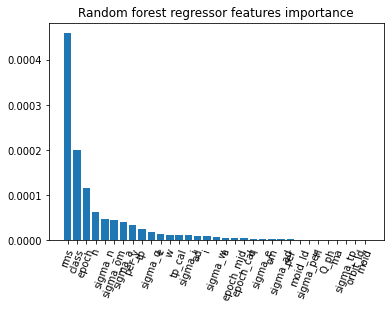

In [0]:
plt.title("Random forest regressor features importance")
plt.bar(range(len(result)), [val[1] for val in result], align='center')
plt.xticks(range(len(result)), [val[0] for val in result])
plt.xticks(rotation=70)
plt.show()

#### Gradient-boosted tree

In [0]:
def gbt_forest_pipeline(df, numerical_features, categorical_features, target_variable, k_fold=5):
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.regression import GBTRegressor

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]


    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")
    
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=True, withMean=True)

    
    if target_variable != "label":
        df = df.withColumnRenamed(target_variable, "label")
    
    gbt = GBTRegressor(featuresCol="std_features", labelCol="label")
    
    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [scaler] + [gbt])
    
    param_grid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [10])\
    .addGrid(gbt.maxIter, [15])\
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )
    
    cv_model = cross_val.fit(df)
    best_pipeline_model = cv_model.bestModel
    
    return cv_model, best_pipeline_model

In [0]:
cv_model, best_pipeline_model_gbt = gbt_forest_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, "diameter")

In [0]:
save_pyspark_model(best_pipeline_model_gbt, "best_pipeline_model_gbt_10_and_15")

In [0]:
predictions_train = best_pipeline_model_gbt.transform(train_df)
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_train)))
print("R2: {:.3f}".format(evaluate_model(predictions_train, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_train)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 3.198
R2: 0.884
Adjusted R2: 0.884
***** Training Set *****

In [0]:
predictions_val = best_pipeline_model_gbt.transform(test_df)
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_val)))
print("R2: {:.3f}".format(evaluate_model(predictions_val, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_val)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 7.006
R2: 0.502
Adjusted R2: 0.497
***** Test Set *****